In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import matplotlib
import scipy
import copy
import cvxpy
import os
from matplotlib import gridspec

# 3. Dispatches

In [2]:
from matplotlib import gridspec

In [2]:
def load_data(name, folder, date, years_all, sbflag=True):
    
    noev_reference = {'dpdf':{}, 'co2':{}, 'tot_dem':{}, 'net_dem':{}, 'storage_dem':{}}
    for col in ['co2', 'tot_dem', 'storage_dem', 'net_dem']:
        noev_reference[col]['total'] = 0
    for year in years_all:
        if sbflag:
            noev_reference['dpdf'][year] = pd.read_csv(folder+name+str(year)+'_storagebefore_withstorage_dpdf_'+date+'.csv')
        else:
            noev_reference['dpdf'][year] = pd.read_csv(folder+name+str(year)+'_withstorage_dpdf_'+date+'.csv')
        noev_reference['co2'][year] = noev_reference['dpdf'][year].co2_tot.sum()
        noev_reference['tot_dem'][year] = noev_reference['dpdf'][year].total_incl_noncombustion.sum()
        if sbflag:
            noev_reference['storage_dem'][year] = pd.read_csv(folder+name+str(year)+'_storagebefore_storage_after_'+date+'.csv').demand.sum()
        else:
            noev_reference['storage_dem'][year] = pd.read_csv(folder+name+str(year)+'_storage_after_'+date+'.csv').demand.sum()
        noev_reference['net_dem'][year] = noev_reference['dpdf'][year].demand.sum() + noev_reference['storage_dem'][year]
            
    return noev_reference

In [3]:
def load_data_co2(name, folder, date, years, sbflag=True, pricestring='01'):
    
    noev_reference = {'dpdf':{}, 'co2':{}, 'tot_dem':{}, 'net_dem':{}, 'storage_dem':{}}
    for col in ['co2', 'tot_dem', 'storage_dem', 'net_dem']:
        noev_reference[col]['total'] = 0
    for year in years:
        if sbflag:
            noev_reference['dpdf'][year] = pd.read_csv(folder+name+str(year)+'_co2price_'+pricestring+'dolperkg'+'_storagebefore_withstorage_dpdf_'+date+'.csv')
        else:
            noev_reference['dpdf'][year] = pd.read_csv(folder+name+str(year)+'_co2price_'+pricestring+'dolperkg'+'_withstorage_dpdf_'+date+'.csv')
        noev_reference['co2'][year] = noev_reference['dpdf'][year].co2_tot.sum()
        noev_reference['tot_dem'][year] = noev_reference['dpdf'][year].total_incl_noncombustion.sum()
        if sbflag:
            noev_reference['storage_dem'][year] = pd.read_csv(folder+name+str(year)+'_co2price_'+pricestring+'dolperkg'+'_storagebefore_storage_after_'+date+'.csv').demand.sum()
        else:
            noev_reference['storage_dem'][year] = pd.read_csv(folder+name+str(year)+'_co2price_'+pricestring+'dolperkg'+'_storage_after_'+date+'.csv').demand.sum()
        noev_reference['net_dem'][year] = noev_reference['dpdf'][year].demand.sum() + noev_reference['storage_dem'][year]

        for col in ['co2', 'tot_dem', 'storage_dem', 'net_dem']:
            noev_reference[col]['total'] += noev_reference[col][year]
            
    return noev_reference

In [5]:
date = '20240208'
year_set = np.arange(2023, 2038)

In [6]:
folder1 = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Results_AEFMEF_'+date+'/'
folder2 = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Results_AEFMEF_outputs_'+date+'/'
folder3 = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Results_MRMEF_outputs_'+date+'/'
noev_reference = load_data('noblock_year', folder1, date, years_all = year_set)
uncontrolled = load_data('flat_block_year', folder1, date, years_all = year_set)
controlled_all = {}
for control in ['MEF', 'AEF']:
    controlled_all[control] = load_data('controlled_block_'+control+'_weekdayweekend__year', 
                                        folder2, date, years_all=year_set,
                                        sbflag=False)
for control_val, control_name in {5000:'MRMEF_5000MW', 10000:'MRMEF_10000MW'}.items():
    controlled_all[control_name] = load_data('controlled_block_'+'MRMEF_delta'+str(control_val)+'_5yearsahead_weekdayweekend'+'_year', 
                                             folder3, date, years_all=year_set,
                                             sbflag=False)

In [115]:
folder4 = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Results_MRMEF_outputs_'+'20240214'+'/'
for control_val, control_name in {20000:'MRMEF_20000MW'}.items():
    controlled_all[control_name] = load_data('controlled_block_'+'MRMEF_delta'+str(control_val)+'_5yearsahead_weekdayweekend'+'_year', 
                                             folder4, '20240214', years_all=year_set,
                                             sbflag=False)

In [7]:
folder1_co2 = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Results_AEFMEF_CO2_'+date+'/'
folder2_co2 = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Results_AEFMEF_CO2_outputs_'+date+'/'
folder3_co2 = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Results_MRMEF_outputs_CO2_'+date+'/'
noev_reference_co2 = load_data_co2('noblock_year', folder1_co2, date, years=year_set)
uncontrolled_co2 = load_data_co2('flat_block_year', folder1_co2, date, years=year_set)
controlled_all_co2 = {}
for control in ['MEF', 'AEF']:
    controlled_all_co2[control] = load_data_co2('controlled_block_'+control+'_weekdayweekend_year', 
                                                folder2_co2, date, years=year_set,
                                                sbflag=False)
for control_val, control_name in {5000:'MRMEF_5000MW', 10000:'MRMEF_10000MW'}.items():
    controlled_all_co2[control_name] = load_data_co2('controlled_block_'+'MRMEF_delta'+str(control_val)+'_5yearsahead_weekdayweekend'+'_year', 
                                                     folder3_co2, date, years=year_set,
                                                     sbflag=False)

In [119]:
# controlled_all_co2

In [120]:
folder4_co2 = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Results_MRMEF_outputs_CO2_'+'20240214'+'/'
for control_val, control_name in {20000:'MRMEF_20000MW'}.items():
    controlled_all_co2[control_name] = load_data_co2('controlled_block_'+'MRMEF_delta'+str(control_val)+'_5yearsahead_weekdayweekend'+'_year', 
                                                     folder4_co2, '20240214', years=year_set,
                                                     sbflag=False)

In [113]:
year = 2023
print('Demand uncontrolled: ', uncontrolled['dpdf'][year]['total_incl_noncombustion'].sum() - noev_reference['dpdf'][year]['total_incl_noncombustion'].sum())
print('Demand AEF: ', controlled_all['AEF']['dpdf'][year]['total_incl_noncombustion'].sum() - noev_reference['dpdf'][year]['total_incl_noncombustion'].sum())
print('Demand MRMEF 5000: ', controlled_all['MRMEF_5000MW']['dpdf'][year]['total_incl_noncombustion'].sum() - noev_reference['dpdf'][year]['total_incl_noncombustion'].sum())


Demand uncontrolled:  11724052.37475884
Demand AEF:  11724052.37037146
Demand MRMEF 5000:  11724052.369720578


In [9]:
colours_all = {'AEF_2020':'#b2e2e2', 'AEF':'#006d2c', 'MEF_2020':'#bdc9e1', 'MEF':'#045a8d',
               'MRMEF_5000MW':'#fe9929', 'MRMEF_10000MW':'#d95f0e', 'MRMEF_20000MW':'#993404',
               'Uncontrolled Flat':'lightslategrey', 'Uncontrolled Evening':'darkslategrey'}

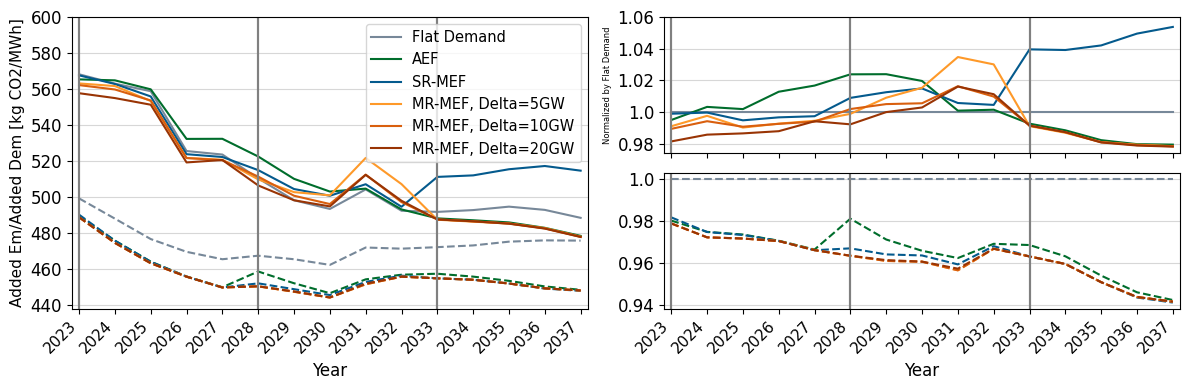

In [122]:
yearmin = 2023
yearmax = 2038
uncont_val = {}
uncont_val_co2 = {}
mrmef_names = {'MRMEF_5000MW':'MR-MEF, Delta=5GW', 'MRMEF_10000MW':'MR-MEF, Delta=10GW', 'MRMEF_20000MW':'MR-MEF, Delta=20GW'}
for year in np.arange(yearmin, yearmax):
    uncont_val[year] = (uncontrolled['co2'][year] - noev_reference['co2'][year])/(uncontrolled['tot_dem'][year] - noev_reference['tot_dem'][year])
for year in np.arange(yearmin, yearmax):
    uncont_val_co2[year] = (uncontrolled_co2['co2'][year] - noev_reference_co2['co2'][year])/(uncontrolled_co2['tot_dem'][year] - noev_reference_co2['tot_dem'][year])
    
max_per_year = {}
fig = plt.figure(tight_layout=True, figsize=(12, 4))
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

for ax in [ax1, ax2, ax3]:
    for year in [2023, 2028, 2033]:
        ax.axvline(year, color='grey')

ax1.plot(np.arange(yearmin, yearmax), [(uncontrolled['co2'][year] - noev_reference['co2'][year])/(uncontrolled['tot_dem'][year] - noev_reference['tot_dem'][year]) for year in np.arange(yearmin, yearmax)], color=colours_all['Uncontrolled Flat'], label='Flat Demand')
ax1.plot(np.arange(yearmin, yearmax), [(controlled_all['AEF']['co2'][year] - noev_reference['co2'][year])/(controlled_all['AEF']['tot_dem'][year] - noev_reference['tot_dem'][year]) for year in np.arange(yearmin, yearmax)], color=colours_all['AEF'], label='AEF')
ax1.plot(np.arange(yearmin, yearmax), [(controlled_all['MEF']['co2'][year] - noev_reference['co2'][year])/(controlled_all['MEF']['tot_dem'][year] - noev_reference['tot_dem'][year]) for year in np.arange(yearmin, yearmax)], color=colours_all['MEF'], label='SR-MEF')
for mrmef_name in ['MRMEF_5000MW', 'MRMEF_10000MW', 'MRMEF_20000MW']:#['MRMEF_5000MW', 'MRMEF_10000MW', 'MRMEF_20000MW']:
    ax1.plot(np.arange(yearmin, yearmax), [(controlled_all[mrmef_name]['co2'][year] - noev_reference['co2'][year])/(controlled_all[mrmef_name]['tot_dem'][year] - noev_reference['tot_dem'][year]) for year in np.arange(yearmin, yearmax)], color=colours_all[mrmef_name], label=mrmef_names[mrmef_name])

ax1.plot(np.arange(yearmin, yearmax), [(uncontrolled_co2['co2'][year] - noev_reference_co2['co2'][year])/(uncontrolled_co2['tot_dem'][year] - noev_reference_co2['tot_dem'][year]) for year in np.arange(yearmin, yearmax)], color=colours_all['Uncontrolled Flat'], linestyle='--')
ax1.plot(np.arange(yearmin, yearmax), [(controlled_all_co2['AEF']['co2'][year] - noev_reference_co2['co2'][year])/(controlled_all_co2['AEF']['tot_dem'][year] - noev_reference_co2['tot_dem'][year]) for year in np.arange(yearmin, yearmax)], color=colours_all['AEF'], linestyle='--')
ax1.plot(np.arange(yearmin, yearmax), [(controlled_all_co2['MEF']['co2'][year] - noev_reference_co2['co2'][year])/(controlled_all_co2['MEF']['tot_dem'][year] - noev_reference_co2['tot_dem'][year]) for year in np.arange(yearmin, yearmax)], color=colours_all['MEF'], linestyle='--')
for mrmef_name in ['MRMEF_5000MW', 'MRMEF_10000MW', 'MRMEF_20000MW']:#['MRMEF_5000MW', 'MRMEF_10000MW', 'MRMEF_20000MW']:
    ax1.plot(np.arange(yearmin, yearmax), [(controlled_all_co2[mrmef_name]['co2'][year] - noev_reference_co2['co2'][year])/(controlled_all_co2[mrmef_name]['tot_dem'][year] - noev_reference_co2['tot_dem'][year]) for year in np.arange(yearmin, yearmax)], color=colours_all[mrmef_name], linestyle='--')
    
ax2.plot(np.arange(yearmin, yearmax), [((uncontrolled['co2'][year] - noev_reference['co2'][year])/(uncontrolled['tot_dem'][year] - noev_reference['tot_dem'][year]))/uncont_val[year] for year in np.arange(yearmin, yearmax)], color=colours_all['Uncontrolled Flat'])
ax2.plot(np.arange(yearmin, yearmax), [((controlled_all['AEF']['co2'][year] - noev_reference['co2'][year])/(controlled_all['AEF']['tot_dem'][year] - noev_reference['tot_dem'][year]))/uncont_val[year] for year in np.arange(yearmin, yearmax)], color=colours_all['AEF'])
ax2.plot(np.arange(yearmin, yearmax), [((controlled_all['MEF']['co2'][year] - noev_reference['co2'][year])/(controlled_all['MEF']['tot_dem'][year] - noev_reference['tot_dem'][year]))/uncont_val[year] for year in np.arange(yearmin, yearmax)], color=colours_all['MEF'])
for mrmef_name in ['MRMEF_5000MW', 'MRMEF_10000MW', 'MRMEF_20000MW']:#['MRMEF_5000MW', 'MRMEF_10000MW', 'MRMEF_20000MW']:
    ax2.plot(np.arange(yearmin, yearmax), [((controlled_all[mrmef_name]['co2'][year] - noev_reference['co2'][year])/(controlled_all[mrmef_name]['tot_dem'][year] - noev_reference['tot_dem'][year]))/uncont_val[year] for year in np.arange(yearmin, yearmax)], color=colours_all[mrmef_name])

ax3.plot(np.arange(yearmin, yearmax), [((uncontrolled_co2['co2'][year] - noev_reference_co2['co2'][year])/(uncontrolled_co2['tot_dem'][year] - noev_reference_co2['tot_dem'][year]))/uncont_val_co2[year] for year in np.arange(yearmin, yearmax)], color=colours_all['Uncontrolled Flat'], linestyle='--')
ax3.plot(np.arange(yearmin, yearmax), [((controlled_all_co2['AEF']['co2'][year] - noev_reference_co2['co2'][year])/(controlled_all_co2['AEF']['tot_dem'][year] - noev_reference_co2['tot_dem'][year]))/uncont_val_co2[year] for year in np.arange(yearmin, yearmax)], color=colours_all['AEF'], linestyle='--')
ax3.plot(np.arange(yearmin, yearmax), [((controlled_all_co2['MEF']['co2'][year] - noev_reference_co2['co2'][year])/(controlled_all_co2['MEF']['tot_dem'][year] - noev_reference_co2['tot_dem'][year]))/uncont_val_co2[year] for year in np.arange(yearmin, yearmax)], color=colours_all['MEF'], linestyle='--')
for mrmef_name in ['MRMEF_5000MW', 'MRMEF_10000MW', 'MRMEF_20000MW']:#['MRMEF_5000MW', 'MRMEF_10000MW', 'MRMEF_20000MW']:
    ax3.plot(np.arange(yearmin, yearmax), [((controlled_all_co2[mrmef_name]['co2'][year] - noev_reference_co2['co2'][year])/(controlled_all_co2[mrmef_name]['tot_dem'][year] - noev_reference_co2['tot_dem'][year]))/uncont_val_co2[year] for year in np.arange(yearmin, yearmax)], color=colours_all[mrmef_name], linestyle='--')

    
ax1.legend(fontsize=10.5, loc='upper right')
ax1.set_ylabel('Added Em/Added Dem [kg CO2/MWh]', fontsize=11)
ax1.set_yticks(np.arange(440, 610, 20))
ax1.set_yticklabels(np.arange(440, 610, 20), fontsize=12)
ax2.set_ylabel('Normalized by Flat Demand', fontsize=6)
ax2.set_yticks(np.arange(0.98, 1.07, 0.02))
ax2.set_yticklabels(np.round(np.arange(0.98, 1.07, 0.02),2), fontsize=12)
ax3.set_yticks(np.arange(0.94, 1.01, 0.02))
ax3.set_yticklabels(np.round(np.arange(0.94, 1.01, 0.02),2), fontsize=12)
for ax in [ax1, ax3]:
    ax.set_xticks(year_set)
    ax.set_xticklabels(year_set, rotation=45, ha='right', fontsize=11)
    ax.set_xlabel('Year', fontsize=12)
    for year in [2023, 2028, 2033]:
        ax.axvline(year, color='grey')
ax2.set_xticks(year_set)
ax2.set_xticklabels([])
for year in [2023, 2028, 2033]:
    ax2.axvline(year, color='grey')

ax1.grid(axis='y', alpha=0.5)
ax1.set_xlim([2022.8, 2037.2])
ax2.grid(axis='y', alpha=0.5)
ax2.set_xlim([2022.8, 2037.2])
ax3.grid(axis='y', alpha=0.5)
ax3.set_xlim([2022.8, 2037.2])

plt.tight_layout()

plt.savefig('../Figures/added_emissions_block_'+'20240216'+'.pdf', bbox_inches='tight')
plt.savefig('../Figures/added_emissions_block_'+'20240216'+'.png', bbox_inches='tight')
plt.show()

In [124]:
results_summary_abs = pd.DataFrame({'Years':np.arange(yearmin, yearmax)})
results_summary_abs['Uncont'] = [(uncontrolled['co2'][year] - noev_reference['co2'][year])/(uncontrolled['tot_dem'][year] - noev_reference['tot_dem'][year]) for year in np.arange(yearmin, yearmax)]
results_summary_abs['AEF'] = [(controlled_all['AEF']['co2'][year] - noev_reference['co2'][year])/(controlled_all['AEF']['tot_dem'][year] - noev_reference['tot_dem'][year]) for year in np.arange(yearmin, yearmax)]
results_summary_abs['SRMEF'] = [(controlled_all['MEF']['co2'][year] - noev_reference['co2'][year])/(controlled_all['MEF']['tot_dem'][year] - noev_reference['tot_dem'][year]) for year in np.arange(yearmin, yearmax)]
for mrmef_name in ['MRMEF_5000MW', 'MRMEF_10000MW', 'MRMEF_20000MW']:
    results_summary_abs[mrmef_name] = [(controlled_all[mrmef_name]['co2'][year] - noev_reference['co2'][year])/(controlled_all[mrmef_name]['tot_dem'][year] - noev_reference['tot_dem'][year]) for year in np.arange(yearmin, yearmax)]


In [123]:
results_summary_abs_co2 = pd.DataFrame({'Years':np.arange(yearmin, yearmax)})
results_summary_abs_co2['Uncont'] = [(uncontrolled_co2['co2'][year] - noev_reference_co2['co2'][year])/(uncontrolled_co2['tot_dem'][year] - noev_reference_co2['tot_dem'][year]) for year in np.arange(yearmin, yearmax)]
results_summary_abs_co2['AEF'] = [(controlled_all_co2['AEF']['co2'][year] - noev_reference_co2['co2'][year])/(controlled_all_co2['AEF']['tot_dem'][year] - noev_reference_co2['tot_dem'][year]) for year in np.arange(yearmin, yearmax)]
results_summary_abs_co2['SRMEF'] = [(controlled_all_co2['MEF']['co2'][year] - noev_reference_co2['co2'][year])/(controlled_all_co2['MEF']['tot_dem'][year] - noev_reference_co2['tot_dem'][year]) for year in np.arange(yearmin, yearmax)]
for mrmef_name in ['MRMEF_5000MW', 'MRMEF_10000MW', 'MRMEF_20000MW']:
    results_summary_abs_co2[mrmef_name] = [(controlled_all_co2[mrmef_name]['co2'][year] - noev_reference_co2['co2'][year])/(controlled_all_co2[mrmef_name]['tot_dem'][year] - noev_reference_co2['tot_dem'][year]) for year in np.arange(yearmin, yearmax)]


In [127]:
results_summary = pd.DataFrame({'Years':np.arange(yearmin, yearmax)})

results_summary['Flat'] = [((uncontrolled['co2'][year] - noev_reference['co2'][year])/(uncontrolled['tot_dem'][year] - noev_reference['tot_dem'][year]))/uncont_val[year] for year in np.arange(yearmin, yearmax)]
results_summary['AEF'] = [((controlled_all['AEF']['co2'][year] - noev_reference['co2'][year])/(controlled_all['AEF']['tot_dem'][year] - noev_reference['tot_dem'][year]))/uncont_val[year] for year in np.arange(yearmin, yearmax)]
results_summary['MEF'] = [((controlled_all['MEF']['co2'][year] - noev_reference['co2'][year])/(controlled_all['MEF']['tot_dem'][year] - noev_reference['tot_dem'][year]))/uncont_val[year] for year in np.arange(yearmin, yearmax)]
for mrmef_name in ['MRMEF_5000MW', 'MRMEF_10000MW', 'MRMEF_20000MW']:#['MRMEF_5000MW', 'MRMEF_10000MW', 'MRMEF_20000MW']:
    results_summary[mrmef_name] = [((controlled_all[mrmef_name]['co2'][year] - noev_reference['co2'][year])/(controlled_all[mrmef_name]['tot_dem'][year] - noev_reference['tot_dem'][year]))/uncont_val[year] for year in np.arange(yearmin, yearmax)]

results_summary_co2 = pd.DataFrame({'Years':np.arange(yearmin, yearmax)})

results_summary_co2['Flat'] = [((uncontrolled_co2['co2'][year] - noev_reference_co2['co2'][year])/(uncontrolled_co2['tot_dem'][year] - noev_reference_co2['tot_dem'][year]))/uncont_val_co2[year] for year in np.arange(yearmin, yearmax)]
results_summary_co2['AEF'] = [((controlled_all_co2['AEF']['co2'][year] - noev_reference_co2['co2'][year])/(controlled_all_co2['AEF']['tot_dem'][year] - noev_reference_co2['tot_dem'][year]))/uncont_val_co2[year] for year in np.arange(yearmin, yearmax)]
results_summary_co2['MEF'] = [((controlled_all_co2['MEF']['co2'][year] - noev_reference_co2['co2'][year])/(controlled_all_co2['MEF']['tot_dem'][year] - noev_reference_co2['tot_dem'][year]))/uncont_val_co2[year] for year in np.arange(yearmin, yearmax)]
for mrmef_name in ['MRMEF_5000MW', 'MRMEF_10000MW', 'MRMEF_20000MW']:#['MRMEF_5000MW', 'MRMEF_10000MW', 'MRMEF_20000MW']:
    results_summary_co2[mrmef_name] = [((controlled_all_co2[mrmef_name]['co2'][year] - noev_reference_co2['co2'][year])/(controlled_all_co2[mrmef_name]['tot_dem'][year] - noev_reference_co2['tot_dem'][year]))/uncont_val_co2[year] for year in np.arange(yearmin, yearmax)]


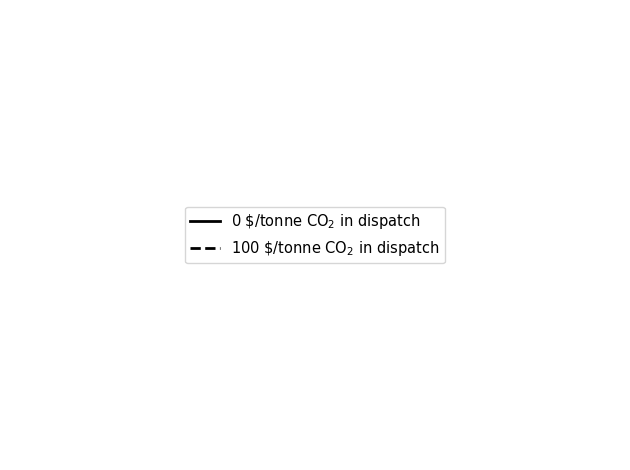

In [21]:
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='k', lw=2, linestyle='-'),
                Line2D([0], [0], color='k', lw=2, linestyle='--')]

fig, ax = plt.subplots()
# lines = ax.plot(data)
ax.legend(custom_lines, ['0 \$/tonne CO$_2$ in dispatch', '100 \$/tonne CO$_2$ in dispatch'], loc='center', fontsize=10.5)
ax.axis('off')
plt.tight_layout()
plt.savefig('../Figures/res1_legend_v3.pdf', bbox_inches='tight')
plt.show()

### EV Cases

In [4]:
folder3 = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Results_AEFMEF_20240208/'
date3 = '20240208'
year_set = np.arange(2023, 2038)

ev_ref = pd.DataFrame(index = year_set, columns=['tot_dem', 'co2'])
for year in ev_ref.index:
    ref = pd.read_csv(folder3+'noblock_year'+str(year)+'_storagebefore_withstorage_dpdf_'+date3+'.csv')
    ev_ref.loc[year, 'tot_dem'] = ref.total_incl_noncombustion.sum()
    ev_ref.loc[year, 'co2'] = ref.co2_tot.sum()
    
folder3a = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Results_AEFMEF_CO2_20240208/'

ev_ref_co2 = pd.DataFrame(index = year_set, columns=['tot_dem', 'co2'])
for year in ev_ref.index:
    ref = pd.read_csv(folder3a+'noblock_year'+str(year)+'_co2price_01dolperkg_storagebefore_withstorage_dpdf_'+date3+'.csv')
    ev_ref_co2.loc[year, 'tot_dem'] = ref.total_incl_noncombustion.sum()
    ev_ref_co2.loc[year, 'co2'] = ref.co2_tot.sum()
    
folder4 = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Results_AEFMEF_EV_20240208/'
date4 = '20240208'

ev_uncont = pd.DataFrame(index = year_set, columns=[case+'_'+col for col in ['tot_dem', 'co2'] for case in ['UniversalHome', 'HighHome', 'LowHome_HighWork']])
for year in ev_ref.index:
    for ev_case in ['UniversalHome', 'HighHome', 'LowHome_HighWork']:
        uncont = pd.read_csv(folder4 + 'uncontrolled_15min_EVs_'+ev_case+'_year'+str(year)+'_withstorage_dpdf_'+date4+'.csv')
        ev_uncont.loc[year, ev_case+'_'+'tot_dem'] = uncont.total_incl_noncombustion.sum()
        ev_uncont.loc[year, ev_case+'_'+'co2'] = uncont.co2_tot.sum()
        
        
folder4a = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Results_AEFMEF_EV_co2_20240208/'
date4 = '20240208'

ev_uncont_co2 = pd.DataFrame(index = year_set, columns=[case+'_'+col for col in ['tot_dem', 'co2'] for case in ['UniversalHome', 'HighHome', 'LowHome_HighWork']])
for year in ev_ref.index:
    for ev_case in ['UniversalHome', 'HighHome', 'LowHome_HighWork']:
        uncont = pd.read_csv(folder4a + 'uncontrolled_15min_co2_EVs_'+ev_case+'_year'+str(year)+'_withstorage_dpdf_'+date4+'.csv')
        ev_uncont_co2.loc[year, ev_case+'_'+'tot_dem'] = uncont.total_incl_noncombustion.sum()
        ev_uncont_co2.loc[year, ev_case+'_'+'co2'] = uncont.co2_tot.sum()
        
cont_cols = [case+'_'+control_case+'_'+reg+'_'+col for control_case in ['AEF', 'MEF'] for reg in ['nonreg', 'reg10'] for col in ['tot_dem', 'co2'] for case in ['UniversalHome', 'HighHome', 'LowHome_HighWork']]
ev_cont = pd.DataFrame(index = year_set, columns=cont_cols)
for year in ev_cont.index:
    for ev_case in ['UniversalHome', 'HighHome', 'LowHome_HighWork']:
        for reg in ['nonreg']:
            for control_case in ['AEF', 'MEF']:
                cont = pd.read_csv(folder4 + 'controlled_15min_EVs_'+control_case+'_weekdayweekend_noevbase_'+ev_case+'_'+reg+'_year'+str(year)+'_withstorage_dpdf_'+date4+'.csv')
                ev_cont.loc[year, ev_case+'_'+control_case+'_'+reg+'tot_dem'] = cont.total_incl_noncombustion.sum()
                ev_cont.loc[year, ev_case+'_'+control_case+'_'+reg+'co2'] = cont.co2_tot.sum()

cont_cols = [case+'_'+control_case+'_'+reg+'_'+col for control_case in ['AEF', 'MEF'] for reg in ['nonreg', 'reg10'] for col in ['tot_dem', 'co2'] for case in ['UniversalHome', 'HighHome', 'LowHome_HighWork']]
ev_cont_co2 = pd.DataFrame(index = year_set, columns=cont_cols)
for year in ev_cont_co2.index:
    for ev_case in ['UniversalHome', 'HighHome', 'LowHome_HighWork']:
        for reg in ['nonreg']:#, 'reg10']:
            for control_case in ['AEF', 'MEF']:
                cont = pd.read_csv(folder4a + 'controlled_15min_co2_EVs_'+control_case+'_weekdayweekend_noevbase_'+ev_case+'_'+reg+'_year'+str(year)+'_withstorage_dpdf_'+date4+'.csv')
                ev_cont_co2.loc[year, ev_case+'_'+control_case+'_'+reg+'tot_dem'] = cont.total_incl_noncombustion.sum()
                ev_cont_co2.loc[year, ev_case+'_'+control_case+'_'+reg+'co2'] = cont.co2_tot.sum()

folder5 = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Results_MRMEF_EV_20240208/'
folder5a = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Results_MRMEF_EV_co2_20240208/'
date5 = '20240208'
for year in ev_cont.index:
    for ev_case in ['UniversalHome', 'HighHome', 'LowHome_HighWork']:
        for reg in ['nonreg']:
            for deltaMW in [5000, 10000]:
                cont = pd.read_csv(folder5 + 'controlled_15min_EVs_MRMEF_delta'+str(deltaMW)+'_5yearsahead_weekdayweekend_noevbase_'+ev_case+'_'+reg+'_year'+str(year)+'_withstorage_dpdf_'+date5+'.csv')
                ev_cont.loc[year, ev_case+'_'+'MRMEF_deltaMW'+str(deltaMW)+'_'+reg+'tot_dem'] = cont.total_incl_noncombustion.sum()
                ev_cont.loc[year, ev_case+'_'+'MRMEF_deltaMW'+str(deltaMW)+'_'+reg+'co2'] = cont.co2_tot.sum()

                
for year in ev_cont_co2.index:
    for ev_case in ['UniversalHome', 'HighHome', 'LowHome_HighWork']:
        for reg in ['nonreg']:
            for deltaMW in [5000, 10000]:
                cont = pd.read_csv(folder5a + 'controlled_15min_co2_EVs_MRMEF_delta'+str(deltaMW)+'_5yearsahead_weekdayweekend_noevbase_'+ev_case+'_'+reg+'_year'+str(year)+'_withstorage_dpdf_'+date5+'.csv')
                ev_cont_co2.loc[year, ev_case+'_'+'MRMEF_deltaMW'+str(deltaMW)+'_'+reg+'tot_dem'] = cont.total_incl_noncombustion.sum()
                ev_cont_co2.loc[year, ev_case+'_'+'MRMEF_deltaMW'+str(deltaMW)+'_'+reg+'co2'] = cont.co2_tot.sum()


In [6]:
def plot_emissions_cases(ev_uncont, ev_ref, ev_cont, ax1, ev_case, uncontrolled, noev_reference, linestyle='-', inlegend=True):
    colours_all = {'AEF': '#006d2c', 'MEF': '#045a8d', 'MRMEF_deltaMW5000': '#fe9929', 'MRMEF_deltaMW10000': '#d95f0e','MRMEF_deltaMW20000': '#993404',
     'Uncontrolled Flat': 'lightslategrey',
     'Uncontrolled Evening': 'darkslategrey'}
    mrmef_names = {'MRMEF_deltaMW5000':'MR-MEF, Delta=5GW', 'MRMEF_deltaMW10000':'MR-MEF, Delta=10GW', 'MRMEF_deltaMW20000':'MR-MEF, Delta=20GW'}
    
    if inlegend:
        ax1.plot(np.arange(yearmin, yearmax), [(uncontrolled['co2'][year] - noev_reference['co2'][year])/(uncontrolled['tot_dem'][year] - noev_reference['tot_dem'][year]) for year in np.arange(yearmin, yearmax)], color=colours_all['Uncontrolled Flat'], label='Flat Demand', linestyle=linestyle)
        ax1.plot(np.arange(yearmin, yearmax), [(ev_uncont.loc[year, ev_case+'_co2'] - ev_ref.loc[year, 'co2'])/(ev_uncont.loc[year, ev_case+'_tot_dem'] - ev_ref.loc[year, 'tot_dem']) for year in np.arange(yearmin, yearmax)], color=colours_all['Uncontrolled Evening'], label='Uncontrolled EV Demand', linestyle=linestyle)
        ax1.plot(np.arange(yearmin, yearmax), [(ev_cont.loc[year, ev_case+'_AEF_nonregco2'] - ev_ref.loc[year, 'co2'])/(ev_cont.loc[year, ev_case+'_AEF_nonregtot_dem'] - ev_ref.loc[year, 'tot_dem']) for year in np.arange(yearmin, yearmax)], color=colours_all['AEF'], label='AEF', linestyle=linestyle)
        ax1.plot(np.arange(yearmin, yearmax), [(ev_cont.loc[year, ev_case+'_MEF_nonregco2'] - ev_ref.loc[year, 'co2'])/(ev_cont.loc[year, ev_case+'_MEF_nonregtot_dem'] - ev_ref.loc[year, 'tot_dem']) for year in np.arange(yearmin, yearmax)], color=colours_all['MEF'], label='SR-MEF', linestyle=linestyle)
        for mrmef_name in ['MRMEF_deltaMW5000', 'MRMEF_deltaMW10000']:#['MRMEF_5000MW', 'MRMEF_10000MW', 'MRMEF_20000MW']:
            ax1.plot(np.arange(yearmin, yearmax), [(ev_cont.loc[year, ev_case+'_'+mrmef_name+'_nonregco2'] - ev_ref.loc[year, 'co2'])/(ev_cont.loc[year, ev_case+'_'+mrmef_name+'_nonregtot_dem']- ev_ref.loc[year, 'tot_dem']) for year in np.arange(yearmin, yearmax)], color=colours_all[mrmef_name], label=mrmef_names[mrmef_name], linestyle=linestyle)
    else:
        ax1.plot(np.arange(yearmin, yearmax), [(uncontrolled['co2'][year] - noev_reference['co2'][year])/(uncontrolled['tot_dem'][year] - noev_reference['tot_dem'][year]) for year in np.arange(yearmin, yearmax)], color=colours_all['Uncontrolled Flat'], linestyle=linestyle)
        ax1.plot(np.arange(yearmin, yearmax), [(ev_uncont.loc[year, ev_case+'_co2'] - ev_ref.loc[year, 'co2'])/(ev_uncont.loc[year, ev_case+'_tot_dem'] - ev_ref.loc[year, 'tot_dem']) for year in np.arange(yearmin, yearmax)], color=colours_all['Uncontrolled Evening'], linestyle=linestyle)
        ax1.plot(np.arange(yearmin, yearmax), [(ev_cont.loc[year, ev_case+'_AEF_nonregco2'] - ev_ref.loc[year, 'co2'])/(ev_cont.loc[year, ev_case+'_AEF_nonregtot_dem'] - ev_ref.loc[year, 'tot_dem']) for year in np.arange(yearmin, yearmax)], color=colours_all['AEF'], linestyle=linestyle)
        ax1.plot(np.arange(yearmin, yearmax), [(ev_cont.loc[year, ev_case+'_MEF_nonregco2'] - ev_ref.loc[year, 'co2'])/(ev_cont.loc[year, ev_case+'_MEF_nonregtot_dem'] - ev_ref.loc[year, 'tot_dem']) for year in np.arange(yearmin, yearmax)], color=colours_all['MEF'], linestyle=linestyle)
        for mrmef_name in ['MRMEF_deltaMW5000', 'MRMEF_deltaMW10000']:#['MRMEF_5000MW', 'MRMEF_10000MW', 'MRMEF_20000MW']:
            ax1.plot(np.arange(yearmin, yearmax), [(ev_cont.loc[year, ev_case+'_'+mrmef_name+'_nonregco2'] - ev_ref.loc[year, 'co2'])/(ev_cont.loc[year, ev_case+'_'+mrmef_name+'_nonregtot_dem']- ev_ref.loc[year, 'tot_dem']) for year in np.arange(yearmin, yearmax)], color=colours_all[mrmef_name], linestyle=linestyle)
    return ax1

def plot_emissions_cases_normed(ev_uncont, ev_ref, ev_cont, ax1, ev_case, uncontrolled, noev_reference, uncont_val, linestyle='-'):
    colours_all = {'AEF': '#006d2c', 'MEF': '#045a8d', 'MRMEF_deltaMW5000': '#fe9929', 'MRMEF_deltaMW10000': '#d95f0e','MRMEF_deltaMW20000': '#993404',
     'Uncontrolled Flat': 'lightslategrey',
     'Uncontrolled Evening': 'darkslategrey'}
    mrmef_names = {'MRMEF_deltaMW5000':'MR-MEF, Delta=5GW', 'MRMEF_deltaMW10000':'MR-MEF, Delta=10GW', 'MRMEF_deltaMW20000':'MR-MEF, Delta=20GW'}
    
    ax1.plot(np.arange(yearmin, yearmax), [(uncontrolled['co2'][year] - noev_reference['co2'][year])/(uncontrolled['tot_dem'][year] - noev_reference['tot_dem'][year])/uncont_val[year] for year in np.arange(yearmin, yearmax)], color=colours_all['Uncontrolled Flat'], label='Flat Demand', linestyle=linestyle)
    ax1.plot(np.arange(yearmin, yearmax), [(ev_uncont.loc[year, ev_case+'_co2'] - ev_ref.loc[year, 'co2'])/(ev_uncont.loc[year, ev_case+'_tot_dem'] - ev_ref.loc[year, 'tot_dem'])/uncont_val[year] for year in np.arange(yearmin, yearmax)], color=colours_all['Uncontrolled Evening'], label='Uncontrolled EV Demand', linestyle=linestyle)
    ax1.plot(np.arange(yearmin, yearmax), [(ev_cont.loc[year, ev_case+'_AEF_nonregco2'] - ev_ref.loc[year, 'co2'])/(ev_cont.loc[year, ev_case+'_AEF_nonregtot_dem'] - ev_ref.loc[year, 'tot_dem'])/uncont_val[year] for year in np.arange(yearmin, yearmax)], color=colours_all['AEF'], label='AEF', linestyle=linestyle)
    ax1.plot(np.arange(yearmin, yearmax), [(ev_cont.loc[year, ev_case+'_MEF_nonregco2'] - ev_ref.loc[year, 'co2'])/(ev_cont.loc[year, ev_case+'_MEF_nonregtot_dem'] - ev_ref.loc[year, 'tot_dem'])/uncont_val[year] for year in np.arange(yearmin, yearmax)], color=colours_all['MEF'], label='SR-MEF', linestyle=linestyle)
    for mrmef_name in ['MRMEF_deltaMW5000', 'MRMEF_deltaMW10000']:#['MRMEF_5000MW', 'MRMEF_10000MW', 'MRMEF_20000MW']:
        ax1.plot(np.arange(yearmin, yearmax), [(ev_cont.loc[year, ev_case+'_'+mrmef_name+'_nonregco2'] - ev_ref.loc[year, 'co2'])/(ev_cont.loc[year, ev_case+'_'+mrmef_name+'_nonregtot_dem']- ev_ref.loc[year, 'tot_dem'])/uncont_val[year] for year in np.arange(yearmin, yearmax)], color=colours_all[mrmef_name], label=mrmef_names[mrmef_name], linestyle=linestyle)
    return ax1

In [12]:
def summary_emissions_cases_normed(ev_uncont, ev_ref, ev_cont, ev_case, uncontrolled, noev_reference, uncont_val, linestyle='-'):
    
    summary_here = pd.DataFrame({'Years':np.arange(yearmin, yearmax)})
    
    summary_here['uncont flat'] = [(uncontrolled['co2'][year] - noev_reference['co2'][year])/(uncontrolled['tot_dem'][year] - noev_reference['tot_dem'][year])/uncont_val[year] for year in np.arange(2023, 2038)]
    summary_here['uncont ev'] = [(ev_uncont.loc[year, ev_case+'_co2'] - ev_ref.loc[year, 'co2'])/(ev_uncont.loc[year, ev_case+'_tot_dem'] - ev_ref.loc[year, 'tot_dem'])/uncont_val[year] for year in np.arange(2023, 2038)]
    summary_here['aef ev'] = [(ev_cont.loc[year, ev_case+'_AEF_nonregco2'] - ev_ref.loc[year, 'co2'])/(ev_cont.loc[year, ev_case+'_AEF_nonregtot_dem'] - ev_ref.loc[year, 'tot_dem'])/uncont_val[year] for year in np.arange(2023, 2038)]
    summary_here['mef ev'] = [(ev_cont.loc[year, ev_case+'_MEF_nonregco2'] - ev_ref.loc[year, 'co2'])/(ev_cont.loc[year, ev_case+'_MEF_nonregtot_dem'] - ev_ref.loc[year, 'tot_dem'])/uncont_val[year] for year in np.arange(2023, 2038)]
    for mrmef_name in ['MRMEF_deltaMW5000', 'MRMEF_deltaMW10000']:#['MRMEF_5000MW', 'MRMEF_10000MW', 'MRMEF_20000MW']:
        summary_here[mrmef_name+' ev'] = [(ev_cont.loc[year, ev_case+'_'+mrmef_name+'_nonregco2'] - ev_ref.loc[year, 'co2'])/(ev_cont.loc[year, ev_case+'_'+mrmef_name+'_nonregtot_dem']- ev_ref.loc[year, 'tot_dem'])/uncont_val[year] for year in np.arange(2023, 2038)]
    return summary_here

In [10]:
date = '20240208'
folder1_co2 = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Results_AEFMEF_CO2_'+date+'/'
folder2_co2 = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Results_AEFMEF_CO2_outputs_'+date+'/'
folder3_co2 = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Results_MRMEF_outputs_CO2_'+date+'/'

In [14]:

folder1 = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Results_AEFMEF_20240208/'
folder1a = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Results_AEFMEF_co2_20240208/'
date1 = '20240208'
uncontrolled = load_data('flat_block_year', folder1, date1, years_all = year_set)
uncontrolled_co2 = load_data_co2('flat_block_year', folder1a, date1, years = year_set)

noev_reference = load_data('noblock_year', folder1, date1, years_all = year_set)
noev_reference_co2 = load_data_co2('noblock_year', folder1_co2, date1, years = year_set)


yearmin = 2023
yearmax = 2038
uncont_val = {}
uncont_val_co2 = {}
mrmef_names = {'MRMEF_5000MW':'MR-MEF, Delta=5GW', 'MRMEF_10000MW':'MR-MEF, Delta=10GW'}#, 'MRMEF_20000MW':'MR-MEF, Delta=20GW'}
for year in np.arange(yearmin, yearmax):
    uncont_val[year] = (uncontrolled['co2'][year] - noev_reference['co2'][year])/(uncontrolled['tot_dem'][year] - noev_reference['tot_dem'][year])
for year in np.arange(yearmin, yearmax):
    uncont_val_co2[year] = (uncontrolled_co2['co2'][year] - noev_reference_co2['co2'][year])/(uncontrolled_co2['tot_dem'][year] - noev_reference_co2['tot_dem'][year])
    

summaries_ev = {scen:{'flat_noco2':None, 'flat_co2':None, 'uncont_noco2':None, 'uncont_co2':None} for scen in ['UniversalHome', 'HighHome', 'LowHome_HighWork']}

for evnamehere in ['UniversalHome', 'HighHome', 'LowHome_HighWork']:
    print('--'*5, evnamehere, '--'*5)
    summaries_ev[evnamehere]['flat_noco2'] = summary_emissions_cases_normed(ev_uncont, ev_ref, ev_cont, evnamehere, uncontrolled, noev_reference, uncont_val)
    summaries_ev[evnamehere]['flat_co2'] = summary_emissions_cases_normed(ev_uncont_co2, ev_ref_co2, ev_cont_co2, evnamehere, uncontrolled_co2, noev_reference_co2, uncont_val_co2, linestyle='--')

    uncont_val_evhere = {}
    for year in np.arange(yearmin, yearmax):
        uncont_val_evhere[year] = (ev_uncont.loc[year, evnamehere+'_co2'] - noev_reference['co2'][year])/(ev_uncont.loc[year, evnamehere+'_tot_dem'] - noev_reference['tot_dem'][year])
    uncont_val_co2_evhere = {}
    for year in np.arange(yearmin, yearmax):
        uncont_val_co2_evhere[year] = (ev_uncont_co2.loc[year, evnamehere+'_co2'] - noev_reference_co2['co2'][year])/(ev_uncont_co2.loc[year, evnamehere+'_tot_dem'] - noev_reference_co2['tot_dem'][year])
        
    summaries_ev[evnamehere]['uncont_noco2'] = summary_emissions_cases_normed(ev_uncont, ev_ref, ev_cont, evnamehere, uncontrolled, noev_reference, uncont_val_evhere)
    summaries_ev[evnamehere]['uncont_co2'] = summary_emissions_cases_normed(ev_uncont_co2, ev_ref_co2, ev_cont_co2, evnamehere, uncontrolled_co2, noev_reference_co2, uncont_val_co2_evhere, linestyle='--')


---------- UniversalHome ----------
---------- HighHome ----------
---------- LowHome_HighWork ----------


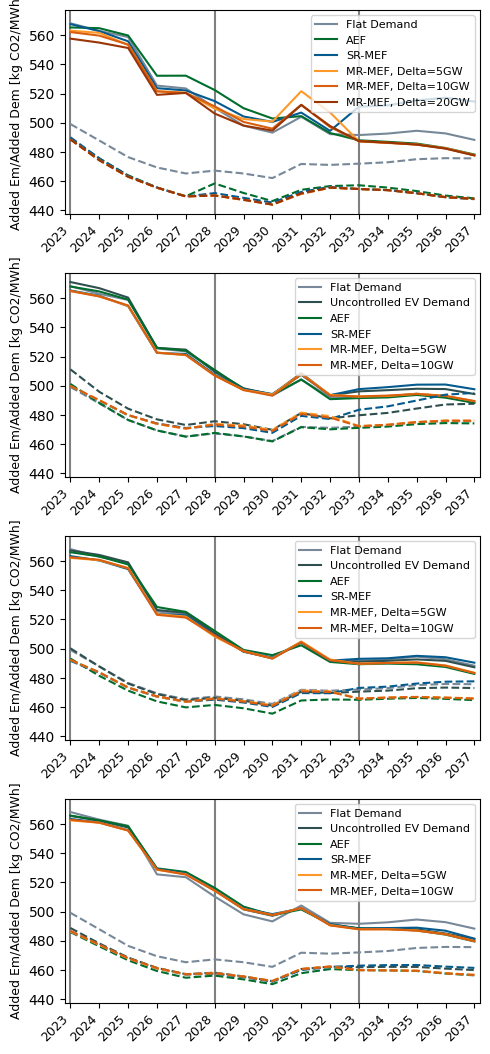

In [137]:


folder1 = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Results_AEFMEF_20240208/'
folder1a = '/Volumes/mtec_nas_sustec_energydb/Siobhan/LRMEF/Results_AEFMEF_co2_20240208/'
date1 = '20240208'
uncontrolled = load_data('flat_block_year', folder1, date1, years_all = year_set)
uncontrolled_co2 = load_data_co2('flat_block_year', folder1a, date1, years = year_set)

noev_reference = load_data('noblock_year', folder1, date1, years_all = year_set)
noev_reference_co2 = load_data_co2('noblock_year', folder1_co2, date1, years = year_set)


yearmin = 2023
yearmax = 2038
uncont_val = {}
uncont_val_co2 = {}
mrmef_names = {'MRMEF_5000MW':'MR-MEF, Delta=5GW', 'MRMEF_10000MW':'MR-MEF, Delta=10GW', 'MRMEF_20000MW':'MR-MEF, Delta=20GW'}#, 'MRMEF_20000MW':'MR-MEF, Delta=20GW'}
for year in np.arange(yearmin, yearmax):
    uncont_val[year] = (uncontrolled['co2'][year] - noev_reference['co2'][year])/(uncontrolled['tot_dem'][year] - noev_reference['tot_dem'][year])
for year in np.arange(yearmin, yearmax):
    uncont_val_co2[year] = (uncontrolled_co2['co2'][year] - noev_reference_co2['co2'][year])/(uncontrolled_co2['tot_dem'][year] - noev_reference_co2['tot_dem'][year])
    
max_per_year = {}
fig, axes = plt.subplots(4, 1, figsize=(5, 4*(8/3)), sharex=False, sharey=True)
for i in range(4):
    for year in [2023, 2028, 2033]:
        axes[i].axvline(year, color='grey')
        axes[i].set_xlim([2022.8, 2037.2])
        axes[i].set_xticks(year_set)
        axes[i].set_xticklabels(year_set, fontsize=9, rotation=45, ha='right')

ax1 = axes[0]
ax1.plot(np.arange(yearmin, yearmax), [(uncontrolled['co2'][year] - noev_reference['co2'][year])/(uncontrolled['tot_dem'][year] - noev_reference['tot_dem'][year]) for year in np.arange(yearmin, yearmax)], color=colours_all['Uncontrolled Flat'], label='Flat Demand')
ax1.plot(np.arange(yearmin, yearmax), [(controlled_all['AEF']['co2'][year] - noev_reference['co2'][year])/(controlled_all['AEF']['tot_dem'][year] - noev_reference['tot_dem'][year]) for year in np.arange(yearmin, yearmax)], color=colours_all['AEF'], label='AEF')
ax1.plot(np.arange(yearmin, yearmax), [(controlled_all['MEF']['co2'][year] - noev_reference['co2'][year])/(controlled_all['MEF']['tot_dem'][year] - noev_reference['tot_dem'][year]) for year in np.arange(yearmin, yearmax)], color=colours_all['MEF'], label='SR-MEF')
for mrmef_name in ['MRMEF_5000MW', 'MRMEF_10000MW', 'MRMEF_20000MW']:#['MRMEF_5000MW', 'MRMEF_10000MW', 'MRMEF_20000MW']:
    ax1.plot(np.arange(yearmin, yearmax), [(controlled_all[mrmef_name]['co2'][year] - noev_reference['co2'][year])/(controlled_all[mrmef_name]['tot_dem'][year] - noev_reference['tot_dem'][year]) for year in np.arange(yearmin, yearmax)], color=colours_all[mrmef_name], label=mrmef_names[mrmef_name])

ax1.plot(np.arange(yearmin, yearmax), [(uncontrolled_co2['co2'][year] - noev_reference_co2['co2'][year])/(uncontrolled_co2['tot_dem'][year] - noev_reference_co2['tot_dem'][year]) for year in np.arange(yearmin, yearmax)], color=colours_all['Uncontrolled Flat'], linestyle='--')
ax1.plot(np.arange(yearmin, yearmax), [(controlled_all_co2['AEF']['co2'][year] - noev_reference_co2['co2'][year])/(controlled_all_co2['AEF']['tot_dem'][year] - noev_reference_co2['tot_dem'][year]) for year in np.arange(yearmin, yearmax)], color=colours_all['AEF'], linestyle='--')
ax1.plot(np.arange(yearmin, yearmax), [(controlled_all_co2['MEF']['co2'][year] - noev_reference_co2['co2'][year])/(controlled_all_co2['MEF']['tot_dem'][year] - noev_reference_co2['tot_dem'][year]) for year in np.arange(yearmin, yearmax)], color=colours_all['MEF'], linestyle='--')
for mrmef_name in ['MRMEF_5000MW', 'MRMEF_10000MW', 'MRMEF_20000MW']:#['MRMEF_5000MW', 'MRMEF_10000MW', 'MRMEF_20000MW']:
    ax1.plot(np.arange(yearmin, yearmax), [(controlled_all_co2[mrmef_name]['co2'][year] - noev_reference_co2['co2'][year])/(controlled_all_co2[mrmef_name]['tot_dem'][year] - noev_reference_co2['tot_dem'][year]) for year in np.arange(yearmin, yearmax)], color=colours_all[mrmef_name], linestyle='--')

yearmin = 2023
yearmax = 2038
uncont_val = {}
uncont_val_co2 = {}
mrmef_names = {'MRMEF_5000MW':'MR-MEF, Delta=5GW', 'MRMEF_10000MW':'MR-MEF, Delta=10GW'}#, 'MRMEF_20000MW':'MR-MEF, Delta=20GW'}
for year in np.arange(yearmin, yearmax):
    uncont_val[year] = (uncontrolled['co2'][year] - noev_reference['co2'][year])/(uncontrolled['tot_dem'][year] - noev_reference['tot_dem'][year])
for year in np.arange(yearmin, yearmax):
    uncont_val_co2[year] = (uncontrolled_co2['co2'][year] - noev_reference_co2['co2'][year])/(uncontrolled_co2['tot_dem'][year] - noev_reference_co2['tot_dem'][year])
    
max_per_year = {}
ax1a = axes[1]        
ax1a = plot_emissions_cases(ev_uncont, ev_ref, ev_cont, ax1a, 'UniversalHome', uncontrolled, noev_reference)
ax1a = plot_emissions_cases(ev_uncont_co2, ev_ref_co2, ev_cont_co2, ax1a, 'UniversalHome', uncontrolled_co2, noev_reference_co2, linestyle='--', inlegend=False)
ax4 = axes[2]
ax4 = plot_emissions_cases(ev_uncont, ev_ref, ev_cont, ax4, 'HighHome', uncontrolled, noev_reference)
ax4 = plot_emissions_cases(ev_uncont_co2, ev_ref_co2, ev_cont_co2, ax4, 'HighHome', uncontrolled_co2, noev_reference_co2, linestyle='--', inlegend=False)
ax7 = axes[3]
ax7 = plot_emissions_cases(ev_uncont, ev_ref, ev_cont, ax7, 'LowHome_HighWork', uncontrolled, noev_reference)
ax7 = plot_emissions_cases(ev_uncont_co2, ev_ref_co2, ev_cont_co2, ax7, 'LowHome_HighWork', uncontrolled_co2, noev_reference_co2, linestyle='--', inlegend=False)


for i in range(4):
    axes[i].legend(fontsize=8)
    axes[i].set_ylabel('Added Em/Added Dem [kg CO2/MWh]', fontsize=9)

plt.tight_layout()
plt.savefig('../Figures/added_emissions_all_combined_left_20240216.pdf', bbox_inches='tight')
plt.savefig('../Figures/added_emissions_all_combined_left_20240216.png', bbox_inches='tight')
plt.show()


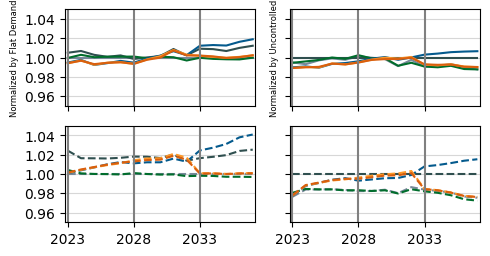

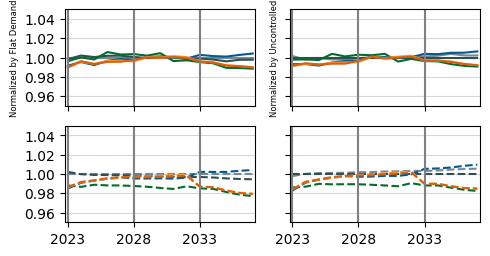

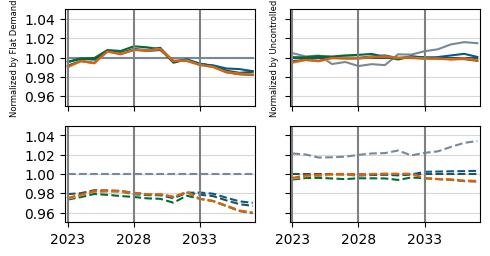

In [17]:
for evnamehere in ['UniversalHome', 'HighHome', 'LowHome_HighWork']:

    fig, axes = plt.subplots(2, 2, figsize=(5, 8/3), sharex=True, sharey=True)
    axes[0, 0] = plot_emissions_cases_normed(ev_uncont, ev_ref, ev_cont, axes[0, 0], evnamehere, uncontrolled, noev_reference, uncont_val)
    axes[1, 0] = plot_emissions_cases_normed(ev_uncont_co2, ev_ref_co2, ev_cont_co2, axes[1, 0], evnamehere, uncontrolled_co2, noev_reference_co2, uncont_val_co2, linestyle='--')

    uncont_val_evhere = {}
    for year in np.arange(yearmin, yearmax):
        uncont_val_evhere[year] = (ev_uncont.loc[year, evnamehere+'_co2'] - noev_reference['co2'][year])/(ev_uncont.loc[year, evnamehere+'_tot_dem'] - noev_reference['tot_dem'][year])
    uncont_val_co2_evhere = {}
    for year in np.arange(yearmin, yearmax):
        uncont_val_co2_evhere[year] = (ev_uncont_co2.loc[year, evnamehere+'_co2'] - noev_reference_co2['co2'][year])/(ev_uncont_co2.loc[year, evnamehere+'_tot_dem'] - noev_reference_co2['tot_dem'][year])
    axes[0, 1] = plot_emissions_cases_normed(ev_uncont, ev_ref, ev_cont, axes[0, 1], evnamehere, uncontrolled, noev_reference, uncont_val_evhere)
    axes[1, 1] = plot_emissions_cases_normed(ev_uncont_co2, ev_ref_co2, ev_cont_co2, axes[1, 1], evnamehere, uncontrolled_co2, noev_reference_co2, uncont_val_co2_evhere, linestyle='--')

    axes[0, 0].set_ylabel('Normalized by Flat Demand', fontsize=6)
    axes[0, 1].set_ylabel('Normalized by Uncontrolled', fontsize=6)

    axes[0, 0].set_xlim([2022.8, 2037.2])
    axes[0, 0].set_ylim([0.95, 1.05])
    axes[0, 0].set_yticks(np.arange(0.96, 1.05, 0.02))
    axes[0, 0].set_ylim([0.95, 1.05])

    for i in range(2):
        for j in range(2):
            for year in [2023, 2028, 2033]:
                axes[i, j].axvline(year, color='grey')
                axes[i, j].grid(axis='y', alpha=0.5)
        axes[1, j].set_xticks([2023, 2028, 2033])
                

    plt.tight_layout()
    plt.savefig('../Figures/'+evnamehere+'_normalized_'+date1+'.pdf', bbox_inches='tight')
    plt.savefig('../Figures/'+evnamehere+'_normalized_'+date1+'.png', bbox_inches='tight')
    plt.show()